# Geomag-IMP Verification and Demonstration

This IPython Notebook verifies that the Geomag-IMP module and associated classes work as intended, and demonstrates its usage for a few simple scenarios. It may offer examples for unit tests, but is not intended to replace them. It may offer similar useage examples to those found in the command line scripts, but is not intended to replace these. It is intended primarily for the technical reviewer required for official USGS software releases.

## Background

The USGS Geomagnetism Program Interpolated Magnetic Perturbation (Geomag-IMP) Python library is primarily for interpolating magnetic field perturbations onto arbitrary geograhic coordinates. It provides two (for now) classes for interpolating magnetic fields. The first is just a thin wrapper for the Gaussian Process regresoor found in the Scikit-Learn machine learning package. It is kind of optimal interpolation, with little or no physical basis.

The second Python class is an adaptation of a technique firstd described by Olaf Amm and Ari Viljanen in their 1999 *Earth Planets Space* article "Ionospheric disturbance magnetic field continuation from the ground to ionosphere using spherical elementary current systems" (A&V-1999). Very briefly, so-called spherical elementary currents (SECs) provide basis fucntions defined by geographic position and amplitude. A given system, often gridded, of these SECs generates a unique interpolated magnetic field by applying Ampere's Law in spherical coordinates.

## Setup

In [1]:
# set things up for inline plotting
%matplotlib notebook

In [2]:
# import standard stuff
import numpy as np
import matplotlib.pyplot as plt

# import geomag_imp
import geomag_imp

In [3]:
# modify default plot properties
from cycler import cycler
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cycler('color', ['r', 'g', 'b', 'm', 'y', 'c']))

## Compare SECs Results with A&V-1999

A&V-1999 contained a figure of sample magnetic disturbance as a function of angle/distance from the pole of a single SEC 100km above the Earth's surface. As expected, there are radial and poloidal magnetic deflections, but not zonal.

We start by reproducing this one idealized case, then one counter-case where the SEC is located 100km below the Earth's surface, and finally, a case where there are two SECs, one directly above and below the same point on Earth's surface.

In [4]:
# create simple secs above and below Earth's surface
lats = np.array([90])
lons = np.array([0])
rads = np.array([6378000 + 100000])
secs_llr = np.array(zip(lats, lons, rads))
secs = geomag_imp.secs(secs_llr)

/Users/erigler/local/lib/python2.7/site-packages/geomag_imp/secs.py:563: RuntimeWarning: invalid value encountered in divide
  arg_tan = y_dot / x_dot
/Users/erigler/local/lib/python2.7/site-packages/geomag_imp/secs.py:587: RuntimeWarning: divide by zero encountered in divide
  TX2_dot[idx_s] = (-fact * 1 / (x3[idx_s] * np.sin(theta_dot[idx_s])) *


<IPython.core.display.Javascript object>


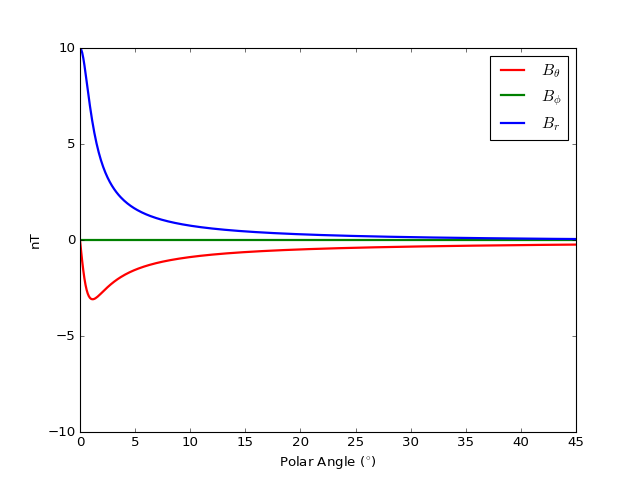

In [5]:
# predict B-field at Earth's surface (like Figure 2 in A&V-1999)
secsR = geomag_imp.secsRegressor(secs, 0.1)
lats = np.linspace(90,0,901)
lons = np.zeros(lats.shape)
rads = np.zeros(lats.shape) + 6378000
pred_llr = np.array(zip(lats, lons, rads))
amps = 1e4
pred = secsR.predict(pred_llr, amps)

plt.figure()
plt.plot(90-lats, pred * 1e9, linewidth=2)
plt.axis([0, 45, -10, 10])
plt.ylabel(r'nT')
plt.xlabel(r'Polar Angle ($^{\circ}$)')
plt.legend([r'$B_{\theta}$', r'$B_{\phi}$', r'$B_r$'])

In [6]:
# For unit tests, estimate Btheta at 90 degrees colatitude, and Brad at 0 degrees colatitude
mu0 = 4 * np.pi * 1e-7 # N / A^2
Btheta90 = -(mu0 * 1e4) / (4. * np.pi * 6378000. * np.sin(np.pi/2.)) * \
        (((6378000./(6378000+100000)) - np.cos(np.pi/2)) / \
         np.sqrt(1 - (2. * 6378000. * np.cos(np.pi/2)) / (6378000+100000) + \
                 (6378000/(6378000.+100000.))**2) + np.cos(np.pi/2))
Brad0 = (mu0 * 1e4) / (4. * np.pi * 6378000.) * \
       (1. / (np.sqrt(1. - 2. * 6378000 * np.cos(0.) / (6378000.+100000) + \
                     (6378000 / (6378000.+100000.))**2)) - 1. )

print Btheta90 * 1e9
print Brad0 * 1e9

-0.110000838606
10.0


Now, place the SEC 100km below the Earth's surface, and predict magnetic disturbance.

In [7]:
# create simple secs below Earth's surface
lats = np.array([90])
lons = np.array([0])
rads = np.array([6378000. - 100000.])
secs_llr = np.array(zip(lats, lons, rads))
secs = geomag_imp.secs(secs_llr)

/Users/erigler/local/lib/python2.7/site-packages/geomag_imp/secs.py:605: RuntimeWarning: divide by zero encountered in divide
  TX2_dot[idx_f] = (-fact * 1 / (x3[idx_f] * np.sin(theta_dot[idx_f])) *
/Users/erigler/local/lib/python2.7/site-packages/geomag_imp/secs.py:610: RuntimeWarning: invalid value encountered in multiply
  1))


<IPython.core.display.Javascript object>


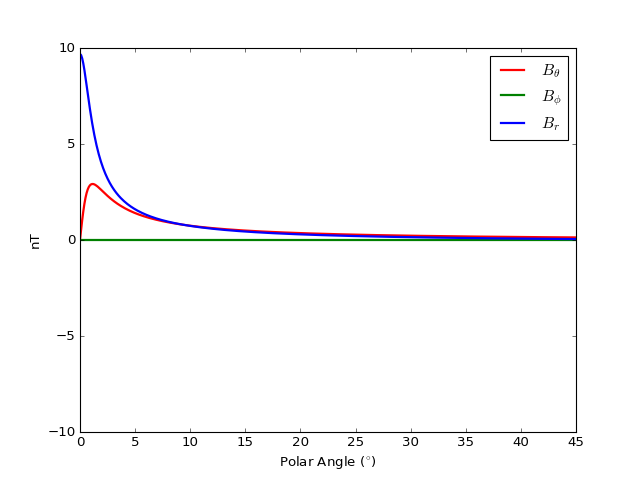

In [8]:
# predict B-field at Earth's surface (NOT like Figure 2 in A&V-1999)
secsR = geomag_imp.secsRegressor(secs, 0.1)
lats = np.linspace(90,0,901)
lons = np.zeros(lats.shape)
rads = np.zeros(lats.shape) + 6378000
pred_llr = np.array(zip(lats, lons, rads))
amps = 1e4
pred = secsR.predict(pred_llr, amps)

plt.figure()
plt.plot(90-lats, pred * 1e9, linewidth=2)
plt.axis([0, 45, -10, 10])
plt.ylabel(r'nT')
plt.xlabel(r'Polar Angle ($^{\circ}$)')
plt.legend([r'$B_{\theta}$', r'$B_{\phi}$', r'$B_r$'])

In [9]:
# For unit tests, estimate Btheta at 90 degrees colatitude, and Brad at 0 degrees colatitude
mu0 = 4 * np.pi * 1e-7 # N / A^2
Btheta90 = -(mu0 * 1e4) / (4. * np.pi * 6378000. * np.sin(np.pi/2.)) * \
        ((6378000. - (6378000.-100000.) * np.cos(np.pi/2.)) / \
         np.sqrt(6378000.**2. - (2. * 6378000. * (6378000.-100000.) * np.cos(np.pi/2.)) + \
                 (6378000.-100000.)**2) - 1.)
Brad0 = (mu0 * 1e4 * (6378000.-100000.)) / (4. * np.pi * 6378000.**2) * \
       (1. / (np.sqrt(1. - 2.*(6378000.-100000.) * np.cos(0.) / 6378000. + \
                     ((6378000.-100000.)/6378000.)**2)) - 1. )

print Btheta90 * 1e9
print Brad0 * 1e9

0.0450499119332
9.68888035375


And finally, place counter SECs at 100km above and 100km below the same point on Earth's surface

In [10]:
# create simple secs above and below Earth's surface
lats = np.array([90, 90])
lons = np.array([0, 0])
rads = np.array([6378000. + 100000., 6378000 - 100000])
secs_llr = np.array(zip(lats, lons, rads))
secs = geomag_imp.secs(secs_llr)

<IPython.core.display.Javascript object>


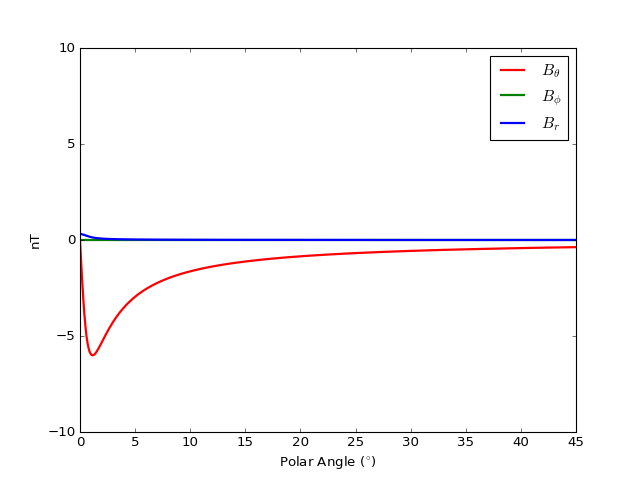

In [11]:
# predict B-field at Earth's surface (NOT like Figure 2 in A&V-1999)
secsR = geomag_imp.secsRegressor(secs, 0.1)
lats = np.linspace(90,0,901)
lons = np.zeros(lats.shape)
rads = np.zeros(lats.shape) + 6378000
pred_llr = np.array(zip(lats, lons, rads))
amps = np.array([1e4, -1e4])
pred = secsR.predict(pred_llr, amps)

plt.figure()
plt.plot(90-lats, pred * 1e9, linewidth=2)
plt.axis([0, 45, -10, 10])
plt.ylabel(r'nT')
plt.xlabel(r'Polar Angle ($^{\circ}$)')
plt.legend([r'$B_{\theta}$', r'$B_{\phi}$', r'$B_r$'])

In [12]:
# For unit tests, estimate Btheta at 90 degrees colatitude, and Brad at 0 degrees colatitude
mu0 = 4 * np.pi * 1e-7 # N / A^2
Btheta90 = -(mu0 * 1e4) / (4. * np.pi * 6378000. * np.sin(np.pi/2.)) * \
        (((6378000./(6378000+100000)) - np.cos(np.pi/2)) / \
         np.sqrt(1 - (2. * 6378000. * np.cos(np.pi/2)) / (6378000+100000) + \
                 (6378000/(6378000.+100000.))**2) + np.cos(np.pi/2))
Btheta90 += -(mu0 * -1e4) / (4. * np.pi * 6378000. * np.sin(np.pi/2.)) * \
        ((6378000. - (6378000.-100000.) * np.cos(np.pi/2.)) / \
         np.sqrt(6378000.**2. - (2. * 6378000. * (6378000.-100000.) * np.cos(np.pi/2.)) + \
                 (6378000.-100000.)**2) - 1.)
    
Brad0 = (mu0 * 1e4) / (4. * np.pi * 6378000.) * \
       (1. / (np.sqrt(1. - 2. * 6378000 * np.cos(0.) / (6378000.+100000) + \
                     (6378000 / (6378000.+100000.))**2)) - 1. )
Brad0 += (mu0 * -1e4 * (6378000.-100000.)) / (4. * np.pi * 6378000.**2) * \
       (1. / (np.sqrt(1. - 2.*(6378000.-100000.) * np.cos(0.) / 6378000. + \
                     ((6378000.-100000.)/6378000.)**2)) - 1. )
    
print Btheta90 * 1e9
print Brad0 * 1e9

-0.155050750539
0.311119646252


## Fitting SECs to Synthetic Data

We start by using predictions from the counter-SECs scenario above as perfect observations to fit. We should get +/- 10,000 Amp SECs, exactly.

In [13]:
# fit the 2 SECs using perfect data, but assume 1nT uncertainty on observations
secsR_perfect = geomag_imp.secsRegressor(secs, 0.1)
secsR_perfect.fit(pred_llr, pred, np.ones(pred.shape) * 1e-9)

print secsR_perfect.secs_.amps
print np.sqrt(secsR_perfect.secs_.amps_var)

[ 10000. -10000.]
[ 286.46658513  299.97580929]


Next, add noise to the perfect observations and fit again.

In [14]:
# fit the 2 SECs using corrupted data with a 1nT sigma, and assume 1nT uncertainty on observations
rs = np.random.RandomState(0) # seed the random number generator for reproducibility
pred_errors = pred + rs.randn(*pred.shape) * 1e-9
secsR_error = geomag_imp.secsRegressor(secs, 0.1)
secsR_error.fit(pred_llr, pred_errors, np.ones(pred.shape) * 1e-9)

print secsR_error.secs_.amps
print np.sqrt(secsR_error.secs_.amps_var)

[  9750.51837154 -10118.38164046]
[ 286.46658513  299.97580929]


Finally, plot the predicted results on top of each other.

<IPython.core.display.Javascript object>


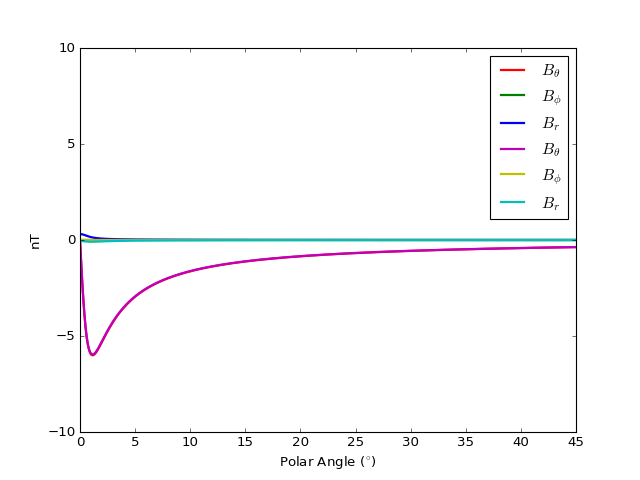

In [15]:
# predict B-field at Earth's surface (NOT like Figure 2 in A&V-1999)
pred_perfect = secsR_perfect.predict(pred_llr)
pred_error = secsR_error.predict(pred_llr)
              
plt.figure()
plt.plot(90-lats, pred_perfect * 1e9)
plt.plot(90-lats, pred_error * 1e9)
plt.axis([0, 45, -10, 10])
plt.ylabel(r'nT')
plt.xlabel(r'Polar Angle ($^{\circ}$)')
plt.legend([r'$B_{\theta}$', r'$B_{\phi}$', r'$B_r$',
            r'$B_{\theta}$', r'$B_{\phi}$', r'$B_r$'])

Fit the SECs multiple times, but using just single observations. Do this once with epsilon set equal to zero (i.e., a "perfect" solution), and once with epsilon equal to a finite value (i.e., a regularized solution). Notice what happens to the solution, its uncertainty, and the singular values, at the pole, and near 30 degrees latitude.

The perfect solutions always return the expected value, except at the pole, where the solution is non-unique. The uncertainty associated with these perfect solutions is a function of latitutde, with a peak near 30 degrees.

The regularized solutions usually return the expected value. **Not** at the pole, but it does return **a** value, which is interesting. Also, **not** at 30 degrees, where the uncertainty normally maximizes. The uncertainty did not maximize at 30 degrees because the SVD solution was truncated here. In other words, it is effectively a different model, and the estimated uncertainties are not comparable.

In [16]:
secsR_singles = geomag_imp.secsRegressor(secs, 0.0)
for i in range(len(pred)):
    if not i%100:
        # only process for polar angle increments of 10 degrees
        secsR_singles.fit([pred_llr[i]], [pred[i]], [np.ones(pred[i].shape) * 1e-9])
        print r"%2d: [%9.1f %9.1f]  [%9.1f %9.1f] [%9.2e %9.2e]"%(
            pred_llr[i][0],
            secsR_singles.secs_.amps[0],
            secsR_singles.secs_.amps[1],
            np.sqrt(secsR_singles.secs_.amps_var[0]),
            np.sqrt(secsR_singles.secs_.amps_var[1]),
            secsR_singles.S_[0],
            secsR_singles.S_[1]
        )

print
        
secsR_singles = geomag_imp.secsRegressor(secs, 0.1)
for i in range(len(pred)):
    if not i%100:
        # only process for polar angle increments of 10 degrees
        secsR_singles.fit([pred_llr[i]], [pred[i]], [np.ones(pred[i].shape) * 1e-9])
        print r"%2d: [%9.1f %9.1f]  [%9.1f %9.1f] [%9.2e %9.2e]"%(
            pred_llr[i][0],
            secsR_singles.secs_.amps[0],
            secsR_singles.secs_.amps[1],
            np.sqrt(secsR_singles.secs_.amps_var[0]),
            np.sqrt(secsR_singles.secs_.amps_var[1]),
            secsR_singles.S_[0],
            secsR_singles.S_[1]
        )

90: [      nan       nan]  [      inf       inf] [ 1.39e-03  0.00e+00]
80: [  10000.0  -10000.0]  [   8659.5    9609.2] [ 1.18e-04  1.02e-04]
70: [  10000.0  -10000.0]  [  18489.0   22899.3] [ 6.14e-05  4.08e-05]
60: [  10000.0  -10000.0]  [  32022.9   44918.8] [ 4.13e-05  2.02e-05]
50: [  10000.0  -10000.0]  [  55590.7   89142.1] [ 3.09e-05  1.00e-05]
40: [  10000.0  -10000.0]  [ 120688.3  220486.9] [ 2.44e-05  4.03e-06]
30: [  10000.0  -10000.0]  [2744248.2 5554977.8] [ 2.00e-05  1.61e-07]
20: [  10000.0  -10000.0]  [ 173240.7  366320.8] [ 1.67e-05  2.50e-06]
10: [  10000.0  -10000.0]  [ 105009.7  215439.4] [ 1.42e-05  4.37e-06]
 0: [  10000.0  -10000.0]  [  91507.4  172082.5] [ 1.22e-05  5.65e-06]

90: [    160.5     155.5]  [    515.8     499.8] [ 1.39e-03  0.00e+00]
80: [  10000.0  -10000.0]  [   8659.5    9609.2] [ 1.18e-04  1.02e-04]
70: [  10000.0  -10000.0]  [  18489.0   22899.3] [ 6.14e-05  4.08e-05]
60: [  10000.0  -10000.0]  [  32022.9   44918.8] [ 4.13e-05  2.02e-05]
50: [

/Users/erigler/local/lib/python2.7/site-packages/geomag_imp/secs.py:330: RuntimeWarning: divide by zero encountered in divide
  W = 1. / S_ # divide by Inf gives zero-weight
/Users/erigler/local/lib/python2.7/site-packages/geomag_imp/secs.py:335: RuntimeWarning: divide by zero encountered in divide
  self.secs_.amps_var = np.sum((self.Vh_.T / S_)**2, axis=1)


## Fitting SECs to Real Data

For now, the USGS is not generating real time XYZF disturbance data (i.e., baseline removed). The script make_svsqdist.py, included with this package, pulls the inputs necesary to do this, but it is too complicated to re-implement in a Notebook.

If/when the USGS makes XYZF disturbance data avaialble directly through its Edge servers, it would be worthwhile to insert a few cells here that demonstrate how one uses this module to generate an interpolated map.

In the meantime, the users is encouraged to experiment with the command-line demonstration scripts stored int he bin/ folder of geomag-imp package.